In [55]:
import warnings
warnings.filterwarnings('ignore')
from numpy import set_printoptions
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
pd.options.display.max_columns=None
import seaborn as sns 
from pandas import read_csv
import io
import base64
import json
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage

import os
import os.path

from urllib.error import HTTPError

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

### CARGUE DE DATOS Y CONEXIÓN A DRIVE

In [56]:
SCOPES = ['https://www.googleapis.com/auth/drive.readonly']

creds = None
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file('C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/credentials.json', SCOPES) # Reemplazar con la ruta correcta
        creds = flow.run_local_server(port=0)
    with open('C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/token.json', 'w') as token:
        token.write(creds.to_json())
        
# Crear una instancia de la API de Drive
drive_service = build('drive', 'v3', credentials=creds)

# ID de la carpeta de Google Drive
folder_id = '1hQeetmO4XIObUefS_nzePqKqq3VksUEC'

# Ruta de destino para guardar los archivos descargados
save_path = 'C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/UNIVERSIDAD-DISTRITAL-PROYECTO/MÓDULO ANALÍTICA PREDICTIVA/DATOS'  # Reemplazar con la ruta deseada

# Función para descargar archivos de la carpeta de Drive
def download_folder(folder_id, save_path):
    results = drive_service.files().list(
        q=f"'{folder_id}' in parents and trashed=false",
        fields='files(id, name)').execute()
    items = results.get('files', [])
    for item in items:
        file_id = item['id']
        file_name = item['name']
        request = drive_service.files().get_media(fileId=file_id)
        fh = io.FileIO(os.path.join(save_path, file_name), 'wb')
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print(f"Descargando {file_name}: {int(status.progress() * 100)}%")
    print("Descarga completa")

# Descargar archivos de la carpeta
download_folder(folder_id, save_path)

# Listar archivos descargados
files = os.listdir(save_path)
print("Archivos descargados:")
for file in files:
    print(file)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=899973764197-biu188dkvsgi2al0fh29udm7keak0lh0.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A55464%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.readonly&state=Uci6uTMTZQakD7r2lXDKy7xseRc0Mo&access_type=offline
Descargando Limpieza de datos 1 UD.ipynb: 100%
Descargando industrial10.csv: 100%
Descargando industrial9.csv: 100%
Descargando industrial8.csv: 100%
Descargando industrial7.csv: 100%
Descargando industrial6.csv: 100%
Descargando industrial5.csv: 100%
Descargando industrial3.csv: 100%
Descargando industrial4.csv: 100%
Descargando industrial2.csv: 100%
Descargando industrial1.csv: 100%
Descarga completa
Archivos descargados:
industrial1.csv
industrial10.csv
industrial2.csv
industrial3.csv
industrial4.csv
industrial5.csv
industrial6.csv
industrial7.csv
industrial8.csv
industrial9.csv
Limpieza de datos 1 UD.ipynb


In [57]:

variables_por_carrera = {
    'industrial': {
        '1': ['PG_ICFES', 'CON_MAT_ICFES', 'FISICA_ICFES','QUIMICA_ICFES','IDIOMA_ICFES','LOCALIDAD', 'PROMEDIO_UNO'],
        '2': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'FISICA_ICFES', 'BIOLOGIA_ICFES', 'IDIOMA_ICFES', 'LOCALIDAD', 'PROMEDIO_UNO', 'CAR_UNO', 'NCC_UNO', 'NAA_UNO', 'NOTA_DIFERENCIAL', 'NOTA_DIBUJO', 'NOTA_QUIMICA', 'NOTA_CFJC', 'NOTA_TEXTOS', 'NOTA_SEMINARIO', 'NOTA_EE_UNO','PROMEDIO_DOS'],
        '3': ['PROMEDIO_UNO', 'NAA_UNO', 'NOTA_DIFERENCIAL', 'NOTA_DIBUJO', 'NOTA_TEXTOS', 'NOTA_EE_UNO', 'PROMEDIO_DOS', 'NCC_DOS', 'NCA_DOS', 'NAA_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_PBASICA', 'NOTA_EE_DOS', 'PROMEDIO_TRES'],
        '4': ['PROMEDIO_UNO', 'NOTA_EE_UNO', 'PROMEDIO_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'NAA_TRES', 'NOTA_MULTIVARIADO', 'NOTA_ESTADISTICA_UNO', 'NOTA_TERMODINAMICA', 'NOTA_TGS', 'NOTA_EE_TRES','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_EE_DOS','PROMEDIO_TRES', 'NAA_TRES', 'NOTA_MULTIVARIADO', 'NOTA_TERMODINAMICA', 'NOTA_ECUACIONES', 'NOTA_ESTADISTICA_DOS', 'NOTA_FISICA_DOS', 'NOTA_MECANICA', 'NOTA_PROCESOSQ','PROMEDIO_CINCO'],
        '6': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_ADMINISTRACION', 'NOTA_LENGUA_UNO', 'NOTA_EI_UNO', 'NOTA_EI_DOS', 'PROMEDIO_SEIS'],
        '7': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_LENGUA_UNO', 'NOTA_EI_DOS', 'PROMEDIO_SEIS', 'NCA_SEIS', 'NOTA_PLINEAL', 'NOTA_DISE O', 'NOTA_EI_TRES','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_LENGUA_UNO','PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO'],
        '9': ['PROMEDIO_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO', 'NCC_OCHO', 'NOTA_LOG_UNO', 'NOTA_GOPERACIONES','NOTA_CALIDAD_DOS', 'NOTA_LENGUA_DOS', 'NOTA_CONTEXTO','PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_SEIS', 'PROMEDIO_SIETE', 'PROMEDIO_OCHO', 'NOTA_CALIDAD_DOS', 'PROMEDIO_NUEVE', 'NAA_NUEVE', 'NOTA_GRADO_UNO', 'NOTA_LOG_DOS', 'NOTA_FINANZAS', 'NOTA_HISTORIA', 'PROMEDIO_DIEZ']
    },
    'sistemas': {
        '1': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'FISICA_ICFES', 'QUIMICA_ICFES', 'IDIOMA_ICFES', 'LOCALIDAD','PROMEDIO_UNO'],
        '2': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'IDIOMA_ICFES', 'PROMEDIO_UNO', 'NOTA_DIFERENCIAL', 'NOTA_PROG_BASICA', 'NOTA_CATEDRA_FJC', 'NOTA_TEXTOS', 'NOTA_SEMINARIO', 'NOTA_CATEDRA_DEM', 'NOTA_CATEDRA_CON', 'NOTA_LOGICA','PROMEDIO_DOS'],
        '3': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'IDIOMA_ICFES', 'PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_PROG_BASICA', 'NOTA_TEXTOS', 'NOTA_CATEDRA_DEM', 'NOTA_INTEGRAL', 'NOTA_PROG_ORIENTADA', 'NOTA_ETICA', 'PROMEDIO_TRES'],
        '4': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'IDIOMA_ICFES', 'PROMEDIO_UNO', 'PROMEDIO_DOS', 'PROMEDIO_TRES', 'NOTA_PROG_BASICA', 'NOTA_TEXTOS', 'NOTA_CATEDRA_DEM', 'NOTA_INTEGRAL', 'NOTA_PROG_ORIENTADA', 'NOTA_ETICA', 'NOTA_FISICA_DOS', 'NOTA_TGS', 'NOTA_PROG_AVANZADA', 'PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NAA_TRES', 'NOTA_MULTIVARIADO', 'NOTA_TERMODINAMICA', 'NOTA_ECUACIONES', 'NOTA_ESTADISTICA_DOS', 'NOTA_FISICA_DOS', 'NOTA_MECANICA', 'NOTA_PROCESOSQ', 'PROMEDIO_CINCO'],
        '6': ['PROMEDIO_UNO', 'NOTA_EE_UNO', 'PROMEDIO_DOS', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_ECONOMIA_UNO', 'NOTA_FISICA_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_ADMINISTRACION', 'NOTA_LENGUA_UNO', 'NOTA_EI_UNO', 'NOTA_EI_DOS','PROMEDIO_SEIS'],
        '7': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_LENGUA_UNO', 'NOTA_EI_DOS', 'PROMEDIO_SEIS', 'NCA_SEIS', 'NOTA_PLINEAL', 'NOTA_DISE O', 'NOTA_EI_TRES','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_LENGUA_UNO', 'PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO'],
        '9': ['PROMEDIO_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO', 'NCC_OCHO', 'NOTA_LOG_UNO', 'NOTA_GOPERACIONES', 'NOTA_CALIDAD_DOS', 'NOTA_LENGUA_DOS', 'NOTA_CONTEXTO', 'PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_SEIS', 'PROMEDIO_SIETE', 'PROMEDIO_OCHO', 'NOTA_CALIDAD_DOS', 'PROMEDIO_NUEVE', 'NAA_NUEVE', 'NOTA_GRADO_UNO', 'NOTA_LOG_DOS', 'NOTA_FINANZAS', 'NOTA_HISTORIA','PROMEDIO_DIEZ']
    },
    'catastral': {
        '1': ['variable1_catastral', 'variable2_catastral', 'variable3_catastral'],
        '2': ['variable4_catastral', 'variable5_catastral', 'variable6_catastral']
    }
}


In [58]:
def cargar_datos(carrera, semestre):
    
    ruta_archivo = f'C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/UNIVERSIDAD-DISTRITAL-PROYECTO/MÓDULO ANALÍTICA PREDICTIVA/DATOS/{carrera}{semestre}.csv'
    datos = pd.read_csv(ruta_archivo,sep=";")
    
    return datos
carrera="industrial"
semestre="1"

In [59]:
datos = cargar_datos(carrera, semestre)
columnas_filtradas = variables_por_carrera[carrera][semestre]
df = datos[columnas_filtradas]
print("DataFrame con columnas filtradas:")
df=df.astype(int)
df

DataFrame con columnas filtradas:


,PG_ICFES,CON_MAT_ICFES,FISICA_ICFES,QUIMICA_ICFES,IDIOMA_ICFES,LOCALIDAD,PROMEDIO_UNO
0,474,65,73,75,79,20,35
1,523,99,69,78,60,1,37
2,483,63,76,82,77,20,28
3,528,88,69,78,75,19,24
4,478,78,69,66,69,8,36
...,...,...,...,...,...,...,...
2003,342,68,0,0,58,11,31
2004,347,69,0,0,71,19,36
2005,348,67,0,0,68,11,29
2006,340,70,0,0,63,11,31


In [60]:
def numero_a_letras(numero):
    numeros_letras = ['cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez']
    return numeros_letras[int(numero)]

semestre_en_letras = numero_a_letras(semestre)
print(semestre_en_letras)


uno


In [61]:
X = df.loc[:, ~df.columns.str.contains(f'PROMEDIO_{semestre_en_letras.upper()}')]
Y = df.loc[:, df.columns.str.contains(f'PROMEDIO_{semestre_en_letras.upper()}')]                                                     
print("Separación de datos usando Pandas") 
print(X.shape, Y.shape)

Separación de datos usando Pandas
(2008, 6) (2008, 1)


In [62]:
X = X.astype('float32')                         
Y = LabelEncoder().fit_transform(Y.astype('str'))                
print(X.shape, Y.shape)

(2008, 6) (2008,)


<Axes: >

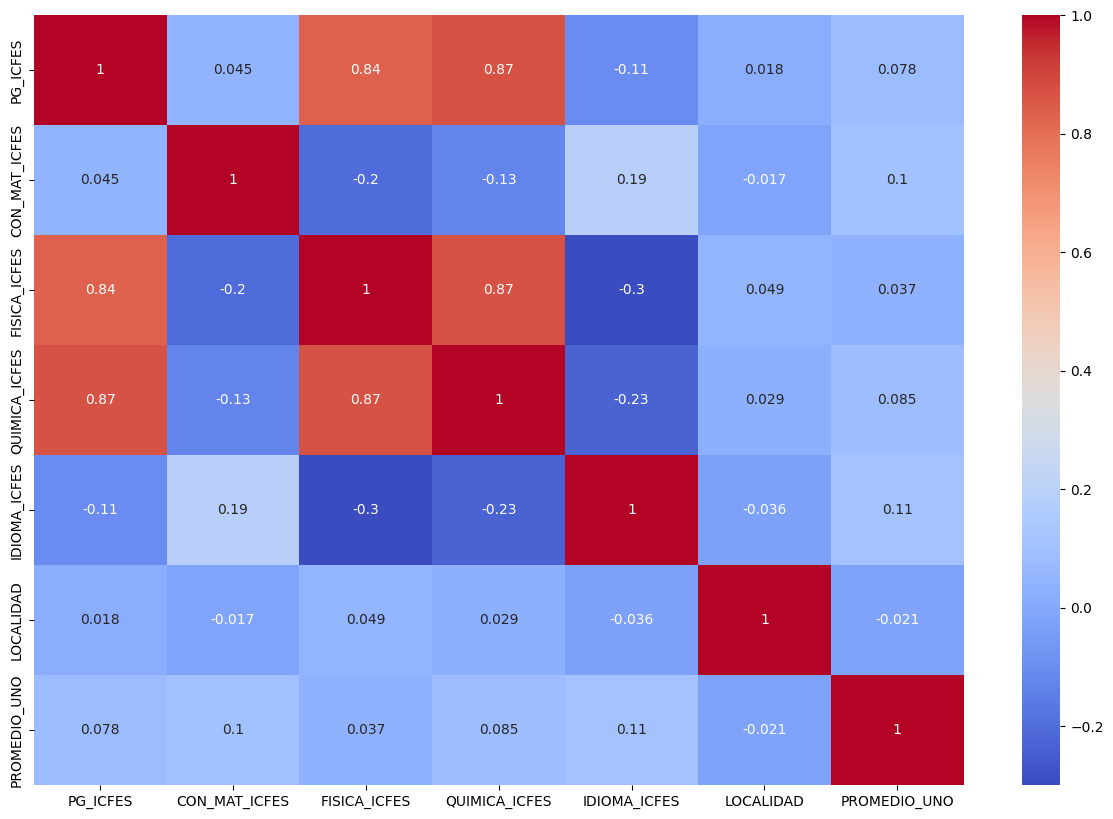

In [76]:
fig, ax = plt.subplots(figsize = (15, 10))
correlacion=df.corr(method='spearman')
sns.heatmap(correlacion,xticklabels=correlacion.columns,yticklabels=correlacion.columns,cmap='coolwarm',annot=True)

In [63]:
X_T_JOHNSON1 = X.copy(deep=True)
def transformacion_johnson(X):
    transformador_johnson = PowerTransformer(method='yeo-johnson', standardize=True).fit(X)
    datos_transformados = transformador_johnson.transform(X)
    set_printoptions(precision=3)
    print(datos_transformados[:5, :])
    datos_transformados_df = pd.DataFrame(data=datos_transformados, columns=X.columns)
    return datos_transformados_df
Xpandas_T_JOHNSON1 = transformacion_johnson(X_T_JOHNSON1)
Xpandas_T_JOHNSON1.head(2)

[[ 1.598 -0.897  1.005  1.046  1.268  1.353]
 [ 2.502  2.983  0.97   1.072 -0.304 -2.363]
 [ 1.767 -1.135  1.031  1.104  1.099  1.353]
 [ 2.592  1.759  0.97   1.072  0.931  1.202]
 [ 1.673  0.621  0.97   0.965  0.432 -0.682]]


,PG_ICFES,CON_MAT_ICFES,FISICA_ICFES,QUIMICA_ICFES,IDIOMA_ICFES,LOCALIDAD
0,1.597922,-0.896989,1.005440,1.046458,1.268133,1.353436
1,2.501767,2.983213,0.970075,1.071632,-0.304398,-2.362881


In [64]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(Xpandas_T_JOHNSON1, Y, test_size=0.3, random_state=2)
print('DATOS: Son {} datos para entrenamiento y {} datos para prueba'.format(X_trn.shape[0], X_tst.shape[0]))

DATOS: Son 1405 datos para entrenamiento y 603 datos para prueba


In [75]:
Y_trn

array([30, 29, 21, ..., 30, 12, 17])

In [65]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [66]:
def entrenar_modelo_knn_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = {
        'n_neighbors': [i for i in range(14, 18, 1)],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'algorithm': ['auto'],
        'p': [i for i in range(1, 6)],
        'weights': ['uniform']
    }
    modelo = KNeighborsRegressor()
    semilla = 5
    num_folds = 10
    kfold = KFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    
    # Usamos el error cuadrático medio como métrica
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn_transformado, Y_trn)

    # Entrenar el modelo con los mejores hiperparámetros
    mejor_modelo = KNeighborsRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    
    # Calcular métricas
    Y_pred = mejor_modelo.predict(X_trn_transformado)
    mse = mean_squared_error(Y_trn, Y_pred)
    mae = mean_absolute_error(Y_trn, Y_pred)
    r2 = r2_score(Y_trn, Y_pred)
    print("Mejor valor PARAMETRO usando k-fold:", grid_resultado.best_params_)
    
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R^2 Score:", r2)
    
    return mejor_modelo

# Ejemplo de uso
X_trn = X_trn 
Y_trn = Y_trn

modelo_knn = entrenar_modelo_knn_con_transformacion(X_trn, Y_trn)


Mejor valor PARAMETRO usando k-fold: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
Mean Squared Error: 58.96638987742191
Mean Absolute Error: 5.748612099644128
R^2 Score: 0.11722907064993182


### SVR

In [67]:
from sklearn.svm import SVR
estimator = SVR()
estimator.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [68]:
def entrenar_modelo_svc_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 'kernel':  ['rbf'], 
            'C': [i/10000 for i in range(8,12,1)],
            'max_iter':[i for i in range(1,3,1)],
            'gamma' : [i/100 for i in range(90,110,5)]}
    modelo = SVR()
    semilla=5
    num_folds=10
    kfold = KFold(n_splits=num_folds, random_state=semilla, shuffle=True)

    # Usamos el error cuadrático medio como métrica
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn_transformado, Y_trn)


    mejor_modelo = SVR(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    
        # Calcular métricas
    Y_pred = mejor_modelo.predict(X_trn_transformado)
    mse = mean_squared_error(Y_trn, Y_pred)
    mae = mean_absolute_error(Y_trn, Y_pred)
    r2 = r2_score(Y_trn, Y_pred)
    print("Mejor valor PARAMETRO usando k-fold:", grid_resultado.best_params_)
    
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R^2 Score:", r2)
    
    
    
    return mejor_modelo

X_trn = X_trn
Y_trn = Y_trn 

modelo_svc = entrenar_modelo_svc_con_transformacion(X_trn, Y_trn)

Mejor valor PARAMETRO usando k-fold: {'C': 0.0008, 'gamma': 0.9, 'kernel': 'rbf', 'max_iter': 1}
Mean Squared Error: 72.0135786843709
Mean Absolute Error: 6.876161880445081
R^2 Score: -0.07809709756994532


In [69]:
from sklearn.tree import DecisionTreeRegressor
estimator = DecisionTreeRegressor()
estimator.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [70]:
def entrenar_modelo_tree_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = {          
            'max_depth':[i for i in range(3,6,1)], 
            'min_samples_leaf' : [i for i in range(1,3,1)], 
            'max_features' : [i for i in range(5,7,1)], 
            'splitter': ["best", "random"],
            'random_state': [i for i in range(1,4,1)]}
    modelo = DecisionTreeRegressor()
    semilla=7
    num_folds=10
    kfold = KFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    
    
    mejor_modelo = DecisionTreeRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    
        # Calcular métricas
    Y_pred = mejor_modelo.predict(X_trn_transformado)
    mse = mean_squared_error(Y_trn, Y_pred)
    mae = mean_absolute_error(Y_trn, Y_pred)
    r2 = r2_score(Y_trn, Y_pred)
    print("Mejor valor PARAMETRO usando k-fold:", grid_resultado.best_params_)
    
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R^2 Score:", r2)
    return mejor_modelo

X_trn = X_trn
Y_trn = Y_trn 

modelo_svc = entrenar_modelo_tree_con_transformacion(X_trn, Y_trn)
    

Mejor valor PARAMETRO usando k-fold: {'max_depth': 4, 'max_features': 6, 'min_samples_leaf': 1, 'random_state': 2, 'splitter': 'random'}
Mean Squared Error: 64.43264479859715
Mean Absolute Error: 5.9772386101276345
R^2 Score: 0.035395148870740356


### NAIVE BAYES

In [71]:
from sklearn.gaussian_process import GaussianProcessRegressor
estimator =  GaussianProcessRegressor()
estimator.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'n_targets': None,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [72]:
def entrenar_modelo_gaussian_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = {}
    modelo = GaussianProcessRegressor()
    semilla=7
    num_folds=10
    kfold = KFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    
        
    mejor_modelo = GaussianProcessRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    
        # Calcular métricas
    Y_pred = mejor_modelo.predict(X_trn_transformado)
    mse = mean_squared_error(Y_trn, Y_pred)
    mae = mean_absolute_error(Y_trn, Y_pred)
    r2 = r2_score(Y_trn, Y_pred)
    print("Mejor valor PARAMETRO usando k-fold:", grid_resultado.best_params_)
    
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R^2 Score:", r2)
    return mejor_modelo

X_trn = X_trn
Y_trn = Y_trn 

modelo_gaussian = entrenar_modelo_gaussian_con_transformacion(X_trn, Y_trn)

Mejor valor PARAMETRO usando k-fold: {}
Mean Squared Error: 0.8386774656426604
Mean Absolute Error: 0.1439769368855981
R^2 Score: 0.9874443714918044


### LDA

In [73]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
estimator =  LinearDiscriminantAnalysis()
estimator.get_params()

{'covariance_estimator': None,
 'n_components': None,
 'priors': None,
 'shrinkage': None,
 'solver': 'svd',
 'store_covariance': False,
 'tol': 0.0001}

In [74]:
def entrenar_modelo_LDA_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 'solver':  ['svd','lsqr','eigen'],
            'n_components':[1,2,3,4,5,None],
            'shrinkage': ['auto',None, 0, 0.001, 0.01, 0.1, 0.5,1]}
    modelo = LinearDiscriminantAnalysis()
    semilla=7
    num_folds=10
    kfold = KFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica= 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    
            
    mejor_modelo = LinearDiscriminantAnalysis(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    
        # Calcular métricas
    Y_pred = mejor_modelo.predict(X_trn_transformado)
    mse = mean_squared_error(Y_trn, Y_pred)
    mae = mean_absolute_error(Y_trn, Y_pred)
    r2 = r2_score(Y_trn, Y_pred)
    print("Mejor valor PARAMETRO usando k-fold:", grid_resultado.best_params_)
    
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R^2 Score:", r2)
    return mejor_modelo

X_trn = X_trn
Y_trn = Y_trn 

modelo_LDA = entrenar_modelo_LDA_con_transformacion(X_trn, Y_trn)

Mejor valor PARAMETRO usando k-fold: {'n_components': 1, 'shrinkage': 0.5, 'solver': 'lsqr'}
Mean Squared Error: 77.44341637010676
Mean Absolute Error: 6.085409252669039
R^2 Score: -0.15938582611549967
